In [12]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [ ]:

import re
from collections import Counter


stopwords = {
    'the','and','for','with','that','this','are','you','all','they',
    'was','but','from','have','their','your','what','when','there',
    'about','then','just'
}

subset = ['Speech', 'Dog Bark', 'Siren', 'Rain', 'Car']
print("Top 20 keywords per class:\n")

for cls in subset:
    
    texts = annotations[annotations['categories'].str.contains(f"'{cls}'")]['text']
    
   
    words = []
    for t in texts:
        tokens = re.findall(r"\b\w+\b", t.lower())
        tokens = [w for w in tokens if len(w) > 2 and w not in stopwords]
        words.extend(tokens)
    cnt = Counter(words)
    
    
    top20 = cnt.most_common(20)
    print(f"{cls}: {[w for w,_ in top10]}")


Top 20 keywords per class:

Speech: ['speaking', 'people', 'man', 'talking', 'background', 'woman', 'voice', 'speaks', 'distance', 'loudly', 'muffled', 'someone', 'person', 'voices', 'indoors', 'male', 'quietly', 'outdoors', 'conversation', 'two']
Dog Bark: ['dog', 'barks', 'loudly', 'repeatedly', 'distance', 'barking', 'dogs', 'growls', 'small', 'once', 'outdoors', 'quietly', 'background', 'high', 'bark', 'nearby', 'aggressively', 'pitched', 'short', 'multiple']
Siren: ['siren', 'sounds', 'police', 'ambulance', 'loud', 'distance', 'loudly', 'away', 'fades', 'emergency', 'wails', 'sirens', 'gradually', 'pattern', 'car', 'repeatedly', 'alarm', 'sounding', 'pitch', 'volume']
Rain: ['rain', 'falling', 'heavy', 'raindrops', 'surface', 'background', 'sounds', 'falls', 'rainfall', 'thunder', 'steadily', 'sound', 'continuously', 'outdoors', 'during', 'hitting', 'pouring', 'continuous', 'light', 'steady']
Car: ['car', 'engine', 'cars', 'driving', 'distance', 'traffic', 'sound', 'passes', 'nois

In [ ]:


annotations = pd.read_csv(
    '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/annotations.csv'
)
subset = ['Speech', 'Dog Bark', 'Siren', 'Rain', 'Car']
mask = annotations['categories'].apply(lambda x: any(cls in x for cls in subset))
subset_ann = annotations[mask].sample(n=800, random_state=47)


keywords = {
    'Speech':   ['speaking','people','man','talking','woman','voice','speaks','someone','person','voices','male','conversation'],
    'Dog Bark': ['dog','barks','barking','dogs','growls','bark'],
    'Siren':    ['siren','police','ambulance','emergency','wails','sirens','alarm'],
    'Rain':     ['rain','raindrops','rainfall','thunder','pouring'],
    'Car':      ['car','engine','cars','driving','traffic','vehicle','drives','vehicles']
}

label_dir = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
results = []

for _, row in subset_ann.iterrows():
    fn = row['filename']
    text = row['text'].lower()
    cats = eval(row['categories'])
    labfile = fn.replace('.mp3', '_labels.npz')
    data = np.load(os.path.join(label_dir, labfile))
    for cls in subset:
        if cls in cats:
            arr = data[cls]  # (time_steps, n_annotators)
            votes = arr.sum(axis=1) >= np.ceil(arr.shape[1]/2)
            start = int(row['onset'] / 0.12)
            end   = int(row['offset'] / 0.12)
            has_event   = votes[start:end].any()
            has_keyword = any(k in text for k in keywords[cls])
            results.append({
                'class': cls,
                'has_keyword': has_keyword,
                'has_event': has_event,
                'file': fn,
                'onset': row['onset'],
                'offset': row['offset'],
                'text': row['text']
            })

dfr = pd.DataFrame(results)
match_rate = (dfr['has_keyword'] & dfr['has_event']).mean()
print(f"Overall keyword–label match rate: {match_rate:.2%}\n")


mismatches = dfr[~(dfr['has_keyword'] & dfr['has_event'])]
print(f"Total mismatches: {len(mismatches)}\n")
print(mismatches[['class','has_keyword','has_event','file','onset','offset','text']].to_string(index=False))
print(dfr['class'].value_counts())

Overall keyword–label match rate: 97.27%

Total mismatches: 22

   class  has_keyword  has_event       file     onset    offset                                                                                                                                                                                    text
  Speech        False       True 437760.mp3  0.361199  1.181577                                                                                                                An announcement is made before the airplane begins its takeoff sequence.
  Speech        False       True 437867.mp3  0.000000  1.931721                                                                                                                                    An announcement is being made in a vintage aircraft.
  Speech        False       True 773535.mp3 19.946981 27.697000                                                                                                              A jet takes off wit

manully select key words based on top 20 freqency,then check the LLM generated labeling function. The result is very good. The mismatched ones are also in the right catergory. You can try listen to the mismatch ones to double confirm.

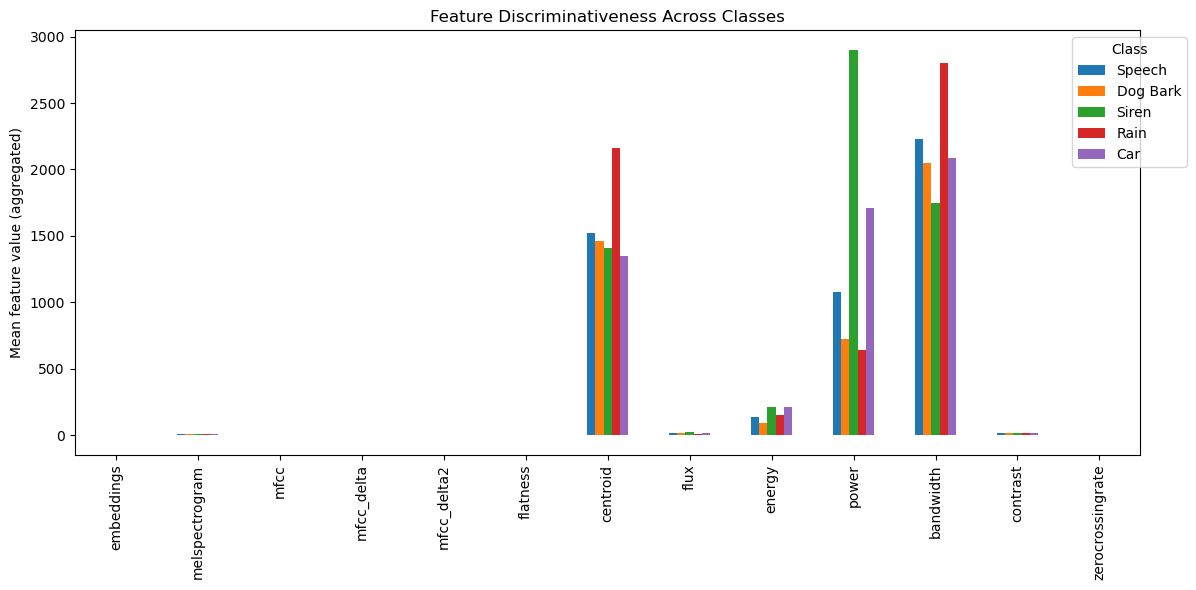

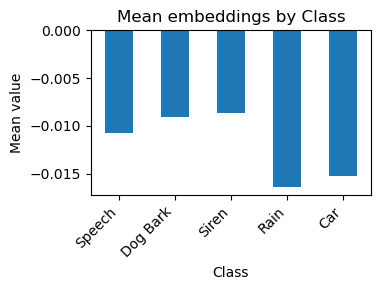

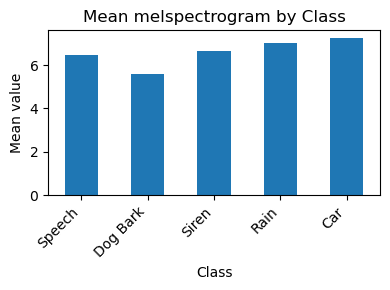

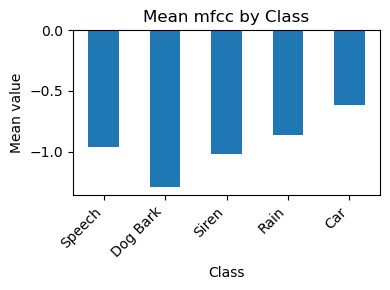

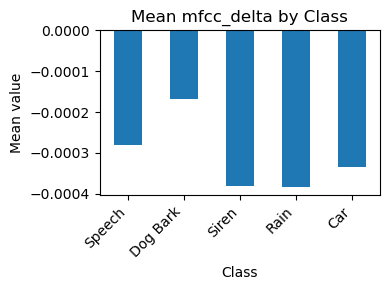

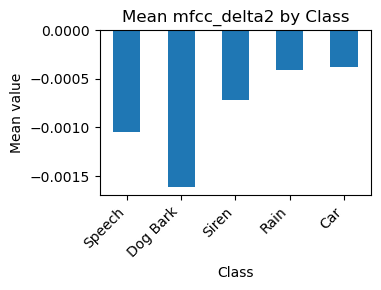

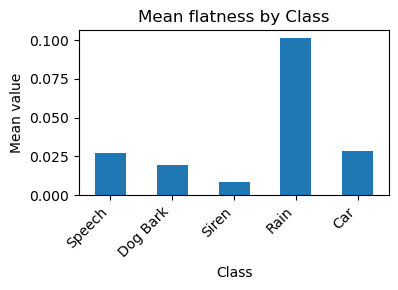

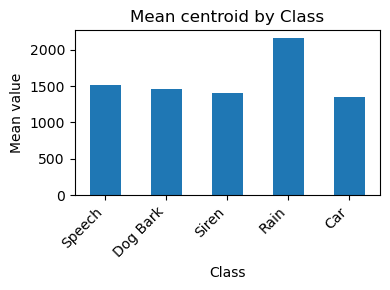

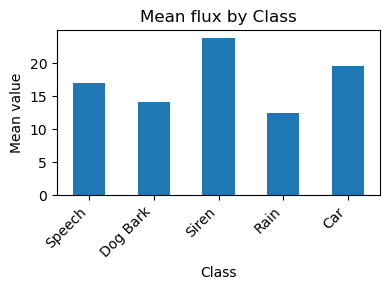

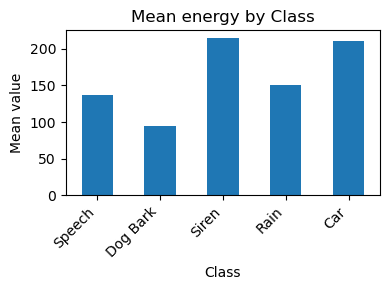

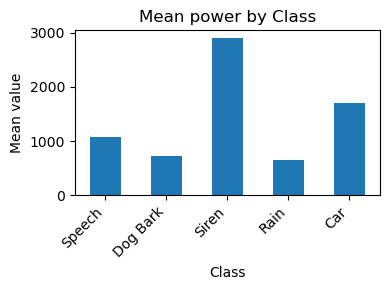

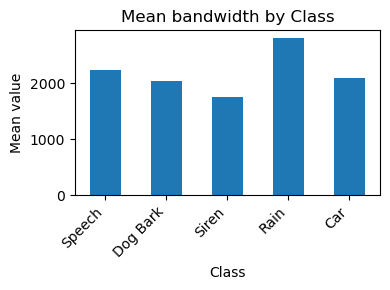

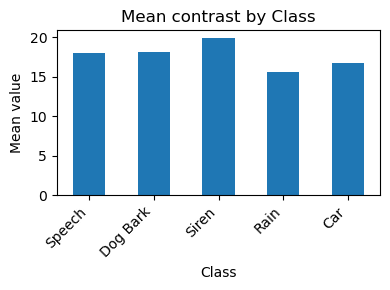

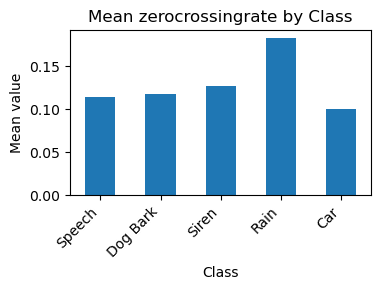

In [ ]:
feat_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
label_dir = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
subset    = ['Speech', 'Dog Bark', 'Siren', 'Rain', 'Car']


feature_list = [
    'embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2',
    'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth',
    'contrast', 'zerocrossingrate'
]


stats = {cls: {} for cls in subset}

for cls in subset:
    
    accum = {feat: [] for feat in feature_list}
    
    for _, row in subset_ann[subset_ann['categories'].str.contains(f"'{cls}'")].iterrows():
        fn = row['filename']
        
        feats = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
        labs  = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))[cls]
        votes = labs.sum(axis=1) >= np.ceil(labs.shape[1]/2)
        idxs  = np.where(votes)[0]
        if len(idxs)==0:
            continue
        
        for feat in feature_list:
            arr = feats[feat]                 # shape (T, D) or (T,1)
            
            scalar = arr.mean(axis=1)[idxs]
            accum[feat].append(scalar)
    
    for feat in feature_list:
        if len(accum[feat])>0:
            stats[cls][feat] = np.concatenate(accum[feat]).mean()
        else:
            stats[cls][feat] = np.nan


df_feat = pd.DataFrame(stats).T  # 行=class，列=feature
df_feat = df_feat[feature_list]  # 保持列顺序


df_feat.T.plot.bar(figsize=(12,6))
plt.ylabel('Mean feature value (aggregated)')
plt.title('Feature Discriminativeness Across Classes')
plt.legend(title='Class', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

for feat in df_feat.columns:
    plt.figure(figsize=(4,3))
    df_feat[feat].plot.bar()
    plt.title(f'Mean {feat} by Class')
    plt.ylabel('Mean value')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Features ranked by ANOVA F-score:
mfcc                9453.933339
embeddings          9141.218369
contrast            6971.885925
flatness            5586.601507
bandwidth           4961.851354
melspectrogram      4809.218556
centroid            2953.877390
energy              2383.578213
zerocrossingrate    1806.606248
power               1650.175941
flux                 821.838189
mfcc_delta2           18.717978
mfcc_delta             0.162851
dtype: float64


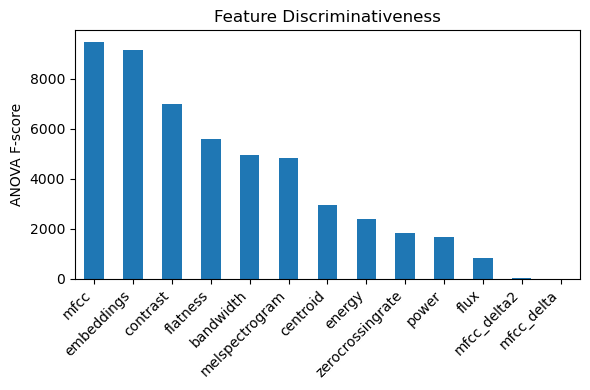

In [ ]:
feat_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
label_dir = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
subset    = ['Speech', 'Dog Bark', 'Siren', 'Rain', 'Car']
feature_list = [
    'embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2',
    'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth',
    'contrast', 'zerocrossingrate'
]

records = []
for _, row in subset_ann.iterrows():
    fn   = row['filename']
    labs = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))

    votes = {cls: (labs[cls].sum(axis=1) >= np.ceil(labs[cls].shape[1]/2)) for cls in subset}
    
    stacked = np.vstack([votes[cls] for cls in subset]).T  # shape (T,5)
    exclusives = np.where(stacked.sum(axis=1)==1)[0]
    if len(exclusives)==0:
        continue
    feats = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
    for i in exclusives:
        
        cls_idx = np.where(stacked[i])[0][0]
        cls_lbl = subset[cls_idx]
        
        row_rec = {'class': cls_lbl}
        for feat in feature_list:
            arr = feats[feat]                 # (T, D)
            row_rec[feat] = arr.mean(axis=1)[i]
        records.append(row_rec)

df = pd.DataFrame(records)
X  = df[feature_list].values
y  = df['class'].values


F, p = f_classif(X, y)
feat_scores = pd.Series(F, index=feature_list).sort_values(ascending=False)
print("Features ranked by ANOVA F-score:")
print(feat_scores)


plt.figure(figsize=(6,4))
feat_scores.plot.bar()
plt.ylabel('ANOVA F-score')
plt.title('Feature Discriminativeness')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

not easy to compare different features' ability with just mean-value on each classed. We use F-score to rank them. This is much better. We can select the top 6 features for the next step.

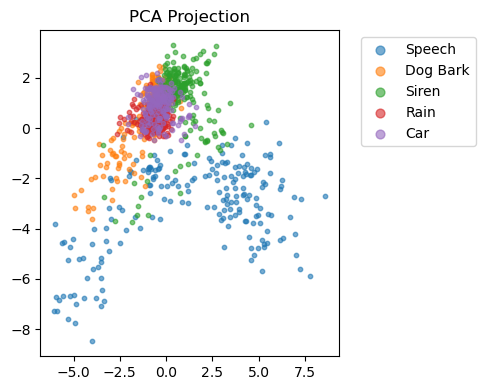

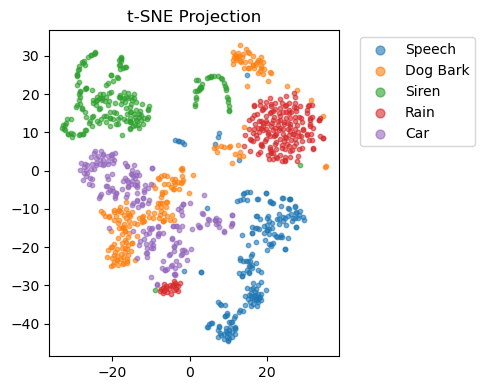

In [ ]:

from sklearn.preprocessing import StandardScaler


n_per_class = 200


X, y = [], []
for cls in subset:
    count = 0
    for _, row in subset_ann[subset_ann['categories'].str.contains(cls)].iterrows():
        if count >= n_per_class: break
        fn = row['filename']
        feats = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
        labs  = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))[cls]
        votes = labs.sum(axis=1) >= np.ceil(labs.shape[1]/2)
        idxs = np.where(votes)[0]
        for i in idxs[:min(len(idxs), n_per_class-count)]:
            vec = np.concatenate([
                feats['mfcc'][i],
                feats['flatness'][i].ravel(),
                feats['centroid'][i].ravel()
            ])
            X.append(vec)
            y.append(cls)
            count += 1
        if count >= n_per_class: break

X = np.array(X)
y = np.array(y)


Xs = StandardScaler().fit_transform(X)


pca = PCA(n_components=2, random_state=47)
Xp = pca.fit_transform(Xs)
plt.figure(figsize=(5,4))
for cls in subset:
    idx = y == cls
    plt.scatter(Xp[idx,0], Xp[idx,1], label=cls, alpha=0.6, s=10)
plt.title('PCA Projection')
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


tsne = TSNE(n_components=2, random_state=47, init='pca', learning_rate='auto')
Xt = tsne.fit_transform(Xs)
plt.figure(figsize=(5,4))
for cls in subset:
    idx = y == cls
    plt.scatter(Xt[idx,0], Xt[idx,1], label=cls, alpha=0.6, s=10)
plt.title('t-SNE Projection')
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


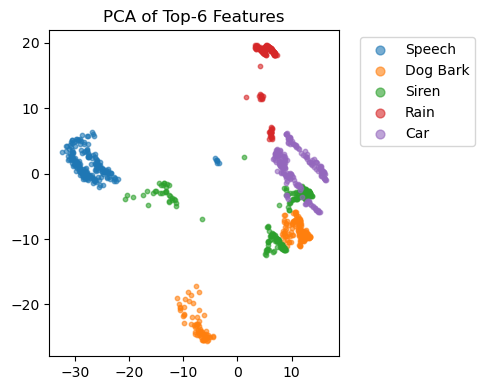

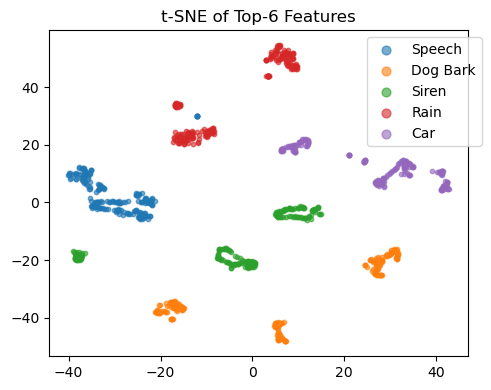

In [ ]:
feat_dir    = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
label_dir   = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
subset      = ['Speech', 'Dog Bark', 'Siren', 'Rain', 'Car']
n_per_class = 200

top_feats = ['mfcc','embeddings','contrast','flatness','bandwidth','melspectrogram']


X, y = [], []
for cls in subset:
    count = 0
    
    for _, row in subset_ann[subset_ann['categories'].str.contains(f"'{cls}'")].iterrows():
        if count >= n_per_class:
            break
        fn    = row['filename']
       
        feats = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
        labs  = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))[cls]
        votes = labs.sum(axis=1) >= np.ceil(labs.shape[1]/2)
        idxs  = np.where(votes)[0]
        for i in idxs:
            if count >= n_per_class:
                break
            
            vec = np.concatenate([
                feats['mfcc'][i],
                feats['embeddings'][i],
                feats['contrast'][i],
                feats['flatness'][i].ravel(),
                feats['bandwidth'][i].ravel(),
                feats['melspectrogram'][i].ravel()
            ])
            X.append(vec)
            y.append(cls)
            count += 1

X = np.array(X)
y = np.array(y)


Xs = StandardScaler().fit_transform(X)


pca = PCA(n_components=2, random_state=47)
Xp  = pca.fit_transform(Xs)
plt.figure(figsize=(5,4))
for cls in subset:
    idx = (y == cls)
    plt.scatter(Xp[idx,0], Xp[idx,1], label=cls, alpha=0.6, s=10)
plt.title('PCA of Top-6 Features')
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


tsne = TSNE(n_components=2, random_state=47, init='pca', learning_rate='auto')
Xt   = tsne.fit_transform(Xs)
plt.figure(figsize=(5,4))
for cls in subset:
    idx = (y == cls)
    plt.scatter(Xt[idx,0], Xt[idx,1], label=cls, alpha=0.6, s=10)
plt.title('t-SNE of Top-6 Features')
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

PCA and t-SNE shows good seperation. Top 6 features works well on the selected sample data. 